# CPSC 536M - Homework 2
Emma Hansen and Naomi Graham

October 2020

In [ ]:
using Pkg

In [ ]:
#Pkg.add("Zygote")
Pkg.add("Random")
Pkg.add("LinearAlgebra")
Pkg.add("ToeplitzMatrices")
Pkg.add("SparseArrays")
Pkg.add("Wavelets")
Pkg.add("LazySets")
Pkg.add("PyPlot")
Pkg.add("FFTW")
Pkg.add("ForwardDiff")

In [1]:
# Load packages
using Images, FileIO, ImageMagick, Zygote, Random, LinearAlgebra, Colors, DSP,ToeplitzMatrices, SparseArrays, Wavelets, LazySets
using PyPlot, FFTW, ForwardDiff

┌ Info: Installing matplotlib via the Conda matplotlib package...
└ @ PyCall /Users/n6graham/.julia/packages/PyCall/BcTLp/src/PyCall.jl:708
┌ Info: Running `conda install -y matplotlib` in root environment
└ @ Conda /Users/n6graham/.julia/packages/Conda/3rPhK/src/Conda.jl:113


Solving environment: ...working... done

# All requested packages already installed.



LoadError: InitError: PyError (PyImport_ImportModule

The Python package matplotlib could not be imported by pyimport. Usually this means
that you did not install matplotlib in the Python version being used by PyCall.

PyCall is currently configured to use the Julia-specific Python distribution
installed by the Conda.jl package.  To install the matplotlib module, you can
use `pyimport_conda("matplotlib", PKG)`, where PKG is the Anaconda
package the contains the module matplotlib, or alternatively you can use the
Conda package directly (via `using Conda` followed by `Conda.add` etcetera).

Alternatively, if you want to use a different Python distribution on your
system, such as a system-wide Python (as opposed to the Julia-specific Python),
you can re-configure PyCall with that Python.   As explained in the PyCall
documentation, set ENV["PYTHON"] to the path/name of the python executable
you want to use, run Pkg.build("PyCall"), and re-launch Julia.

) <class 'ImportError'>
ImportError('dlopen(/Users/n6graham/.julia/conda/3/lib/python3.8/site-packages/matplotlib/ft2font.cpython-38-darwin.so, 2): Library not loaded: @rpath/libpng16.16.dylib\n  Referenced from: /Users/n6graham/.julia/conda/3/lib/libfreetype.6.dylib\n  Reason: Incompatible library version: libfreetype.6.dylib requires version 54.0.0 or later, but libpng16.16.37.0.dylib provides version 16.0.0')
  File "/Users/n6graham/.julia/conda/3/lib/python3.8/site-packages/matplotlib/__init__.py", line 174, in <module>
    _check_versions()
  File "/Users/n6graham/.julia/conda/3/lib/python3.8/site-packages/matplotlib/__init__.py", line 159, in _check_versions
    from . import ft2font

during initialization of module PyPlot

In [2]:
# defining line search function

function linesearch(grad_f,s,d)
    #alpha_upper0 = 1
    #alpha_lower0 = 0
    alpha_mid = 0.5
    alpha_range = 0.5
    stop = 50
    alpha_storage = zeros(stop+1)
    alpha_storage[1] = alpha_mid
    
    for i=1:stop
        val_mid = dot(-grad_f, alpha_mid * s + (1-alpha_mid) * d) / (norm(grad_f)*norm(alpha_mid * s + (1-alpha_mid) * d))
        alpha_upper = alpha_mid + (1/2)*alpha_range
        alpha_lower = alpha_mid - (1/2)*alpha_range
        
        val_upper = dot(-grad_f, alpha_upper * s + (1-alpha_upper) * d) / (norm(grad_f)*norm(alpha_upper * s + (1-alpha_upper) * d))
        val_lower = dot(-grad_f, alpha_lower * s + (1-alpha_lower) * d) / (norm(grad_f)*norm(alpha_lower * s + (1-alpha_lower) * d))
        
        if val_upper > val_mid # note: I think something is wrong with this criteria...
            alpha_mid = deepcopy(alpha_upper)
        elseif val_lower > val_mid
            alpha_mid = deepcopy(alpha_lower)
        end
        
#         if val_upper > val_mid # note: something IS wrong with this one...
#             alpha_lower0 = alpha_mid
#             alpha_mid = alpha_upper0
            
#         elseif val_lower > val_mid
#             alpha_upper0 = alpha_mid
#             alpha_mid = alpha_lower0
            
#         else
#             alpha_upper0 = alpha_upper1
#             alpha_lower0 = alpha_lower1
#         end
        
        alpha_range = (1/2) * alpha_range
        alpha_storage[i+1] = deepcopy(alpha_mid)
    end
    return alpha_mid, alpha_storage
end


linesearch (generic function with 1 method)

In [20]:
# Frank-Wolfe
function frank_wolfe(tau,f,f_grad,K,x0_wav,wav)
    # x0 is a vector
    n = size(x0_wav)[1]
    #x0 = D[:,rand(1:m,(1))]
    
    for k=1:K
        
#         grad_f = gradient(y -> f(y),Array(x0)[:,1])
        
        x0 = idwt(x0_wav, wav, 3)
        grad_f = f_grad(x0)
        
        #s, = get_s(D,grad_f[1])
        
        ind_max = argmax(grad_f)
        s = -tau * sign(grad_f[ind_max])* I(n)[:,ind_max] # from http://www.stat.cmu.edu/~ryantibs/convexopt-S15/scribes/23-cond-grad-scribed.pdf
        
        gamma = 2 / (2+ sqrt(k))
       # gamma = 0.25
        x1_wav = ((1-gamma) .* x0_wav) + (gamma .* s)
        x0_wav = deepcopy(x1_wav)
        #x_history[:,k+1] = x0
        
        if mod(k,100)==0
            print("k is: ")
            println(k)
            #print("max of x is:")
            #println(maximum(x0_wav))
            #print("max of s is: ")
            #println(maximum(s))
            print("value is: ")
            println(f(idwt(x0_wav, wav, 3)))
            #xk = idwt(x0_wav, wt, 3)
            #img_k = reshape(xk,size(blurry_array))
            #imshow(Gray.(img_k))
            #imshow(img_k)
        end
    end
    return x0_wav
end

function ConvolutionMatrix(Kernel,N)
    # N is length of image to be convolved with (must be a square image)
    toeplitzrow = hcat(Kernel[1,:]',zeros(1,N-size(Kernel)[1]))
    for i=2:size(Kernel)[1]
        toeplitzrow = hcat(toeplitzrow,Kernel[i,:]',zeros(1,N-size(Kernel)[1]))
    end
    l = size(toeplitzrow)[2]
    toeplitzrow = hcat(toeplitzrow,zeros(1,N^2-l))

    toeplitz = Circulant(toeplitzrow')'
    
    return sparse(toeplitz)
end

# to solve <s,grad(f)>
function get_s(D,grad_f) # works if you know the atoms
    n,m = size(D)
    stop = 100
    
    IP = ((-grad_f)' * D) ./ (norm(grad_f) .* 1)
    ind_max = argmax(IP)[2]
    s0 = D[:,ind_max]
    val0 = maximum(IP)

    IP_new = deepcopy(IP)
    IP_new[ind_max] = -IP[ind_max]
    
    max_inds = zeros((m,1))
    max_inds[1] = ind_max
    
    for j=2:m
        ind_max = argmax(IP_new)[2]
        d = D[:,ind_max]
        
        alpha, = linesearch(grad_f,s0,d)
        s1 = alpha * s0 + (1-alpha) * d
        
        val1 = (s1' * (-grad_f))[1]
        
        if val1 < val0
            return s0,max_inds
            break
        end
        
        s0 = s1
        IP_new[ind_max] = -IP[ind_max]
        val0 = val1
        max_inds[j] = ind_max
    end
end
        
function get_s(grad_f,tau)
    eps = 0.01
    n = size(grad_f)[1]
    s0 = rand(n)
    s0 = tau .* (s0 ./ sum(x0))
    
    while (s0' * (-grad_f)) > eps
        d = rand(n)
        d = tau .* (d ./ sum(d))
        
        alpha, = linesearch(grad_f,s0,d)
        s1 = alpha .* s0 + (1-alpha) .* d
        
    end
    
end

get_s (generic function with 1 method)

In [ ]:
# Good to know functions
x = [1,2,3,4]

function normsquared(x)
    return sum(x .^ 2)
end

normsquared(x)
gradient(y -> normsquared(y),x)

## Testing linesearch function
The non-random test case is based on the following figure:

In [ ]:
linesearch_file = "linesearch_example.jpg"
linesearch_ex = load(linesearch_file)

In [ ]:
# grad_f = 2 .* (rand(Float16,(5,1)) .- 0.5) 
# s = 2 .* (rand(Float16,(5,1)) .- 0.5)
# d = 2 .* (rand(Float16,(5,1)) .- 0.5)
# print([grad_f,s,d])

grad_f = [-5,-2]
s = [2,4]
d = [6,0]

alpha_mid,alpha_storage = linesearch(grad_f,s,d);

fig = figure(figsize=(8,8))

ax1 = fig.add_subplot(1, 1, 1)
ax1.plot(alpha_storage);
ax1.set_ylabel("alpha");
ax1.set_xlabel("iterations");

## Testing argmin function
The test for the argmin function is the following example.
NOTE: in the figure, what's listed as $\nabla f$ should actually be labelled $-\nabla f$.

In [ ]:
argmin_file = "argmin_example.jpg"
argmin_ex = load(argmin_file)

In [ ]:
D = hcat([-2;5],[2;6],[7;5],[6;0],[2;-4],[-1;1])
grad_f = [-11;-3];

s,max_inds = get_s(D,grad_f)
print("argmin is: ")
println(s)
print("the atoms used are:")
print(max_inds[max_inds .> 0])

## Testing Frank-Wolfe

In [ ]:
function func(x)
    return (1/2) * sum(x .^ 2)
end

D = hcat([-2;5],[2;6],[7;5],[6;0],[2;-4],[-1;1])
K = 50
x_history = frank_wolfe(D,func,K) # does this weird thing where it overwrites D? and outputs that?? I don't understand

# Plotting
X,Y = meshgrid(-3:0.1:8,-5:0.1:7)

fig = figure(figsize=(8,8))
D = hcat([-2;5],[2;6],[7;5],[6;0],[2;-4],[-1;1])

ax1 = fig.add_subplot(1, 1, 1)
ax1.contour(X,Y,reshape([ func(vcat(X[:]',Y[:]')[:,i]) for i in 1:size(X[:])[1] ],size(X)) ) 
ax1.plot(vcat(D[1,:],D[1,1]),vcat(D[2,:],D[2,1]))
ax1.scatter(x_history[1,:],x_history[2,:],c=[1:K+1],cmap="Blues_r")
ax1.plot(x_history[1,1],x_history[2,1],markerfacecolor="none",markeredgecolor="g",linestyle="none",marker="o")
ax1.plot(x_history[1,end],x_history[2,end],markerfacecolor="none",markeredgecolor="r",linestyle="none",marker="o")
ax1.set_ylabel("x2");
ax1.set_xlabel("x1");

In [ ]:
D[1,end]

## Actual project
### Prepare Images

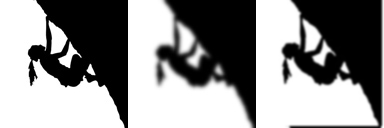

In [4]:
# Clear image
original_path = "smaller_climber128.jpg"
original = load(original_path)
original_grey = Gray.(original)
original_array = convert(Array{Float64}, original_grey)

n, = size(original_array)

# Blurring in photoshop
blurry_path = "smaller_climber_blurry.jpg"
blurry1 = load(blurry_path)
blurry_grey = Gray.(blurry1)
blurry1_array = convert(Array{Float64}, blurry_grey)

# Blurring in Julia
#Kernel = (1/16) .* [1 2 1;2 4 2;1 2 1] # gaussian blur 3x3 from https://en.wikipedia.org/wiki/Kernel_(image_processing)
Kernel = (1/256) .* [1 4 6 4 1; 4 16 24 16 4; 6 24 36 24 6; 4 16 24 16 4; 1 4 6 4 1]
m = size(Kernel)[1]
conv_matrix = ConvolutionMatrix(Kernel,n)
blurry_array = reshape(conv_matrix * original_array[:],size(original_array))


mosaicview(original, blurry1, Gray.(blurry_array); nrow=1)

### Frank-Wolfe Algorithm

In [25]:
# define a function to calculate the objective value

function objective(X_vec,R,B_vec)
# function objective(X_vec,R,B_vec)
# X = idwt(X_wav, wav, 3) # commented out since derivative doesn't like the transform to occur in the objective...
    return (1/2) * sum(( (R * X_vec) - B_vec) .^ 2)
end

##
#function obejctive_gradient(X_vec,R,B_vec,wav)
function obejctive_gradient(X_vec,R,B_vec,wav)
    #gradfx = gradient(y -> objective(y,R,B_vec) , X_vec)
    #return dwt(gradfx[1], wav, 3)
    return dwt((R' * R * X_vec) - (R' * B_vec), wav, 3)
end





obejctive_gradient (generic function with 1 method)

In [28]:
#K = 5001 # frank-wolfe iterations

K= 20001 # frank-wolfe iterations
wt = wavelet(WT.haar) # define wavelet to use in transform
wt = WT.scale(wt, 1) # 1/sqrt(2) scales output to be between 0 and 1 - useful? idk


# define B
BLURRY = blurry_array

# take wave transform of blurry image for starting point
X0_wav = dwt(BLURRY,wt,3)

# parameter 
tau = 1800 # make tau the 1-norm of the wavelet transform of blurry matrix

# defining objective for input data
f = (y -> objective(y,conv_matrix,BLURRY[:]))

# defining gradient for input data
f_grad = (y -> obejctive_gradient(y,conv_matrix,BLURRY[:],wt))

X_wav_sol = frank_wolfe(tau,f,f_grad,K,X0_wav[:],wt); # call frank-wolfe
X_sol = idwt(X_wav_sol, wt, 3); # inverse wavelet transform to bring back to the image domain


## not used ##

#W = idwt(I(n), wt, 3)
#f = (y -> objective(y,conv_matrix,wt,BLURRY)) # set objective function
# X_wav_sol = frank_wolfe(tau,f,K,X0_wav,wt)


k is: 100
value is: 8311.582841411935
k is: 200
value is: 7000.30382755294
k is: 300
value is: 6487.220490482501
k is: 400
value is: 6140.3832994605955
k is: 500
value is: 6018.719730079108
k is: 600
value is: 5885.507454820183
k is: 700
value is: 5950.436371707442
k is: 800
value is: 5662.835122670521
k is: 900
value is: 5695.876104565576
k is: 1000
value is: 5581.157840282915
k is: 1100
value is: 5576.016207049906
k is: 1200
value is: 5473.897833756253
k is: 1300
value is: 5504.763443183907
k is: 1400
value is: 5395.2759282727775
k is: 1500
value is: 5360.197612414093
k is: 1600
value is: 5330.053700705886
k is: 1700
value is: 5361.437728225465
k is: 1800
value is: 5314.748315244651
k is: 1900
value is: 5270.645762143079
k is: 2000
value is: 5273.818687512474
k is: 2100
value is: 5259.475882034129
k is: 2200
value is: 5278.688602198016
k is: 2300
value is: 5198.057638234176
k is: 2400
value is: 5139.1221384091905
k is: 2500
value is: 5044.115718026747
k is: 2600
value is: 5248.346788

### Print Result

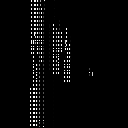

In [29]:
X = reshape(X_sol,size(blurry_array))

Gray.(X)



In [30]:
println(X)


[2.768744489849787e-237 0.0 0.0 4.7916066300446185e-238 -1.0433687875352725e-239 0.0 1.6297335634570387e-239 1.1328641599126205e-238 2.768744489849787e-237 0.0 0.0 9.32852013617028e-239 -5.880613105356356e-239 0.0 7.051221988933051e-241 9.784491403990761e-241 2.768744489849787e-237 0.0 0.0 -1.0871657115545226e-241 -5.0116692828105435e-239 4.506420068118391e-242 -2.4785310374631985e-240 0.0 2.7687444898497524e-237 -3.6763154354985715e-254 0.0 8.834817225509307e-242 -4.3474904436526433e-240 -9.890658701343779e-241 -3.5969184649559083e-239 1.9666509552579652 0.026329173941603504 3.454266598712939e-5 11.348910210665938 0.9462020624663523 0.016389361936234095 5.042917923013939 0.0823322783814784 3.654388924125838e-24 0.6438353177812219 6.753398552548521e-19 1.4060265063506062e-6 9.634718866754033e-10 1.221544012478696 1.8011110155326245e-206 3.477491230241152e-205 6.0632667951708185e-204 9.643215269859276e-203 1.4108964584698278e-201 1.9128144257924145e-200 2.418065547521281e-199 2.86576251

 -2.9981092191601304e-158 -1.2078853057438781e-157 -6.699650250186169e-158 -2.5035398283320457e-156 -1.057100560069465e-155 -3.935815850468273e-155 1.1092031377113905e-154 -7.211086919452232e-154 -2.9771308207424203e-153 0.0 0.0 -2.953030562282284e-240 1.563992847168991e-241 -1.4767803646745607e-239 2.6667403461902792e-239 0.0 0.0 0.0 0.0 -9.390716713117724e-239 7.862898579915842e-238 -6.330990028634498e-239 2.266066585428237e-238 0.0; 2.768744489849787e-237 0.0 0.0 -2.7598063805676392e-238 1.0433687875352725e-239 0.0 -1.6297335634570387e-239 8.66358606690511e-239 2.768744489849787e-237 0.0 0.0 -2.5809699146978562e-239 5.880613105356356e-239 0.0 -7.051221988933051e-241 1.3158453957090933e-240 2.768744489849787e-237 0.0 0.0 1.0871657115545226e-241 5.0116692828105435e-239 -4.506420068118391e-242 2.4785310374631985e-240 0.0 2.765554209525061e-237 1.7773850915711125e-240 0.0 -6.210624128653558e-242 8.377343580068469e-240 -5.277006991983529e-241 3.7374127376677202e-239 1.9391852760068837 0.

 -2.3289003345566074e-171 -1.1533131489354102e-170 -5.624771403578672e-170 -2.702790313753733e-169 -1.2801163103262532e-168 -5.978436732173256e-168 -2.754170314854669e-167 -1.1977181764611145e-166 -4.8579106257264516e-85 -2.383330375752604e-165 -7.177592900246588e-94 -4.514409261144475e-164 -1.849773383002255e-163 -1.1434869367194018e-162 -4.767418956119305e-162 -1.8094673704604845e-161 -5.9118288931413805e-161 -3.974991669526438e-160 -1.5867398394216233e-159 -4.806619368564655e-159 -3.1203131945642003e-158 -1.3076087957932613e-157 -1.907467835345425e-156 -2.6032799518514344e-156 -1.1423598667403455e-155 -4.251115205509091e-155 -1.1092031377113905e-154 -7.49030700360791e-154 -3.0733211019247724e-152 0.0 0.0 -2.953030562282284e-240 1.563992847168991e-241 1.4767803646745607e-239 -3.0118791067011955e-239 0.0 1.3843722449248934e-237 0.0 0.0 -9.390716713117724e-239 7.862898579915842e-238 6.330990028634498e-239 7.432677193522122e-239 0.0; 2.768744489849787e-237 0.0 0.0 2.919159349849785e-240

 -3.374244767680867e-150 -1.2057381955709713e-149 -1.8522027929063234e-179 -1.184501573438273e-178 -6.669877892128735e-178 -3.8763681139802645e-177 -2.207473001436712e-176 -1.2326274325637602e-175 -7.097806711078944e-175 2.698290585347125e-174 -2.0154322508551824e-173 -1.0463078354502288e-172 -5.093113497435819e-172 -2.441645889661605e-171 -1.2085955335194186e-170 -5.8917764643211314e-170 -2.8298719893681007e-169 -1.3397447992138002e-168 -6.254367902621191e-168 -2.8801454738888875e-167 -1.2520321625414687e-166 -4.9635420077271346e-85 -2.489558179705397e-165 -7.342928751424961e-94 -4.712289806740359e-164 -1.9302161662857055e-163 -1.1927142163721707e-162 -4.971050806769976e-162 1.333741053443375e-161 -9.078470839358037e-161 -4.313400805736193e-160 1.1684406355799522e-159 -7.367469553060247e-159 -3.3797845573979363e-158 -1.360500458141456e-157 3.83480185318951e-157 -2.7069730123653143e-156 -1.1875212447039674e-155 3.1240441099799106e-155 -1.828084572583515e-154 -7.780284147795633e-154 2.3

 -1.4838313622789489e-96 -2.0606737791151715e-5 -5.0173389309639986e-33 -9.08497744627303e-136 -1.87771163512119e-189 -1.4976319787849218e-188 -1.0853609766247155e-187 -8.10229231973517e-187 -3.696124525062645e-16 -1.60061404685417e-53 -6.317165523932679e-58 -2.8043338384854046e-119 -2.47039377202238e-69 -1.9187938649149133e-150 -3.4996481808881645e-150 -1.2502797196979834e-149 -1.9536907923981382e-179 -1.248562454851844e-178 -7.026298554250789e-178 -4.081025738956881e-177 -2.322653834744926e-176 -1.2962068845325953e-175 -7.459699618260972e-175 -8.952879477001893e-174 -2.221512358231861e-173 -1.0979604653865232e-172 -5.342037793871086e-172 -2.5598148018117642e-171 -1.2665110672900145e-170 -6.171376907055077e-170 -2.9628919081627276e-169 -1.4021337965987792e-168 -6.542957230557392e-168 -3.011848073879547e-167 -1.3087945007784096e-166 -5.071463864149833e-85 -2.600492981740826e-165 -7.512061863901518e-94 -4.918794206971425e-164 -2.0141372933279217e-163 -1.2440487822808758e-162 -5.18333176

 0.008009107182148813 -7.658985965094998e-107 -1.5673268412159941e-6 -1.5186399488374401e-96 -2.0904696799628307e-5 -0.143832452156727 -2.491559780865831e-10 -3.022060081506257e-29 -1.5940227390619465e-188 -1.1540787291497083e-187 -2.0219660944180698e-34 -3.7520941355545023e-16 -1.4952044317850211e-13 -6.434386707008807e-58 -2.882281576887744e-119 -2.519246339554669e-69 6.387508537831321e-151 -3.6296896423835685e-150 -1.296458751989889e-149 -2.060699209696483e-179 -1.3160630703434048e-178 -7.401630546609093e-178 -4.296412982550565e-177 -2.4438030452044096e-176 -1.3630434238080143e-175 5.543660512553771e-175 -4.210468429516007e-174 -2.3322726402533084e-173 -1.1521464018425997e-172 -5.603049782673139e-172 -2.6836662853705945e-171 -1.3271843781071087e-170 -6.464163180487132e-170 -3.1021258351658977e-169 -1.4674103180433893e-168 -6.844781878920372e-168 -3.1495369477214604e-167 -1.368114900304814e-166 -5.181725722577784e-85 -2.7163421314307853e-165 -7.685079191634717e-94 -5.134296139624224e

 -2.8560601984472806e-200 -3.573028842446864e-199 -4.193952219876894e-198 -4.966979764414514e-9 -0.008009107208962422 -1.8224059188364258e-106 -3.752141010537132e-6 -1.554262638098742e-96 -2.12069561734431e-5 -0.3443900969696345 -5.963922327839065e-10 -3.0220601471488835e-29 -1.6965638991696843e-188 -1.227110350804138e-187 -4.835166732430162e-34 -3.8089096501284925e-16 -3.5785720864095456e-13 -6.675379154301484e-58 -2.962388151221727e-119 -2.569062535995519e-69 -2.1182971786042183e-150 -3.7645398606629596e-150 -1.344335203786495e-149 -2.1735261455167376e-179 -1.3871867923799407e-178 -7.796870187290458e-178 -4.5230884390626755e-177 -2.5712277653791678e-176 -1.4333027692524342e-175 -1.8412998903566657e-174 -4.6454787022551205e-174 -2.4485188725963427e-173 -1.2089890823857968e-172 -5.876732658579579e-172 -2.8134718651531376e-171 -1.3907459553158348e-170 -6.77075323972865e-170 -3.247862262473742e-169 -1.5357071875440463e-168 -7.160445167548518e-168 -3.2934825551867708e-167 -1.4301079570018

 0.0 0.0 -1.0946013539316276e-238 -4.156509804002328e-239 6.468038215411726e-241 1.8025680272465955e-241 -1.8074950102161065 -0.02418230492434716 -3.1694189025113885e-5 -12.322830528769943 -0.869532809638417 -0.015052118421516112 -4.635458929462445 -0.07567942244438827 -0.4656084209665084 -0.0002915212890674891 -2.677392515405618 -0.0020286127648646833 -0.2623792082598228 -4.9786678055414396e-141 -3.1638372023514035e-206 -5.987802532434608e-205 -1.0254455822162975e-203 -1.604610810566077e-202 0.040299369474883974 -3.093842303417542e-200 -3.862503773069652e-199 -1.0057356803578331e-11 -3.3638516439834576 -1.4407331063721207e-20 -1.0305234998596781e-106 -2.1535466027984946e-6 -1.5907184129897112e-96 -2.1513577864661608e-5 -0.19774540710089283 -3.421871090681285e-10 -6.456659409556877e-37 -1.805644516252366e-188 -1.3047243590268556e-187 -1.3386606578615548e-8 -3.8665838427206835e-16 -5.665562664432465 -1.2624800797356453e-20 -6.509960923529459e-22 -2.619861321137573e-69 7.131172200254887e

 -2.244197193921149e-239 -1.763759797953482e-238 0.0; 2.768744489849787e-237 0.0 0.0 1.170927901298311e-240 1.0338257803320536e-241 -2.703852040867591e-241 -3.0185061950366185e-239 5.885690231519331e-241 2.768744489849787e-237 0.0 0.0 1.4804714515442767e-240 1.4314510804594536e-241 -4.4003866547472104e-241 -1.9801739946363267e-239 4.6860591015281074e-241 2.768744489849787e-237 0.0 0.0 1.3691820783611282e-240 3.432831757769772e-240 -4.135303121327788e-241 -9.171890256280861e-241 6.710436633388295e-241 2.768744489849787e-237 0.0 0.0 1.3855868799001156e-238 4.156509804002328e-239 -6.468038215411726e-241 -1.8025680272465955e-241 -1.7822483045854114 -0.023841883256296104 -3.1242782803443496e-5 -12.493423993687449 -0.8573716495332789 -0.014840083431470572 -4.570818885487031 -0.07461639676986012 -0.4590886948481311 -0.00028738576639921045 -2.640016490274247 -0.001999934254417263 -0.25870182433642264 -5.32067068820812e-141 -3.473975656771814e-206 -6.553179779469181e-205 -1.1189546569499043e-20

 -9.041870059396511e-157 -3.421312127906606e-156 1.0594710272635769e-155 -6.0110746949916564e-155 -2.2993667596445762e-154 6.908624478535e-154 0.0 0.0 0.0 1.823085492732492e-238 0.0 1.3810852091104585e-240 2.6269778161774795e-240 0.0 0.0 0.0 0.0 1.7920044484391797e-238 4.387653456799008e-238 2.40033139510468e-239 -1.6412116804541017e-238 0.0; 2.768744489849787e-237 0.0 0.0 -1.27282082717194e-238 0.0 1.7198619648193142e-239 -2.3221317527462427e-240 7.647648453694031e-240 2.768744489849787e-237 0.0 0.0 -6.994205848964245e-239 0.0 1.6400718212603802e-239 3.7527875826059244e-239 -2.5492161512312734e-241 2.7687444898497393e-237 -4.635354244759068e-254 0.0 -1.2840297561736466e-238 -9.277923669643543e-242 2.2980091512051266e-239 7.63970743312169e-240 1.8920432228329902e-239 2.767210981608927e-237 -1.533508240825981e-240 0.0 -1.359534611248639e-238 -1.0486704582036568e-239 2.6322794868459056e-239 1.749551320562191e-241 -1.7573536227496345 -0.02350624536442109 -3.07977942924595e-5 8.75793104309

 -3.377218600397354e-165 -8.611613977701148e-94 -6.3610138731658784e-164 -2.5995469224677087e-163 -1.6016072087214001e-162 -6.660216812108464e-162 2.6356551869465265e-161 -1.2108929311363317e-160 -5.739749708059118e-160 2.340608409493342e-159 -9.762854062654692e-159 -4.4688458270359064e-158 1.5279681864828978e-157 -9.780509775412701e-157 -3.557399064787557e-156 -1.0594710272635769e-155 -6.246731851857877e-155 -2.3889077376874533e-154 -6.908624478535e-154 0.0 0.0 0.0 1.823085492732492e-238 0.0 -7.54162652575689e-240 2.8655529962541474e-240 0.0 1.3843722449248934e-237 0.0 0.0 1.7920044484391797e-238 4.387653456799008e-238 -4.789794365339202e-239 -1.6403103964404787e-238 0.0; 2.768744489849787e-237 0.0 0.0 2.1680830464006878e-238 0.0 -1.7198619648193142e-239 2.3221317527462427e-240 1.222311656042598e-238 2.768744489849787e-237 0.0 0.0 1.5602683860835383e-238 0.0 -1.6400718212603802e-239 -3.7527875826059244e-239 5.681378054692676e-239 2.7680499709921835e-237 -6.945188575564563e-241 0.0 1.9

 4.1347689623093005e-177 -3.31437812970549e-176 -1.9371279404718368e-175 -1.1098169101359314e-174 -5.938330871598247e-174 -3.1219623866451942e-173 -1.5378087288441795e-172 -7.457655455066626e-172 -3.5622518375010465e-171 -1.7568908747299293e-170 -8.534479668635271e-170 -4.0851458533433426e-169 -1.9275864708824403e-168 -8.969441367673844e-168 -4.117408955777649e-167 -1.7845441046799196e-166 -5.89534795915524e-85 -3.5274453476380994e-165 -8.809877027946933e-94 -6.6392997145583204e-164 -2.712381438021467e-163 -1.6704285153547376e-162 -6.94417580676033e-162 -3.1024526275974526e-161 -1.2617132546651283e-160 4.227538364948572e-160 -2.580192350366336e-159 -1.0163137842242842e-158 3.288483881607895e-158 -1.8678450229599314e-157 -1.0172039919155992e-156 2.615496705197501e-156 -1.6189463273599509e-155 -6.7459770165441035e-155 1.754980954722484e-154 -1.0540292261156106e-153 0.0 0.0 8.051912327587483e-240 9.930029161857742e-240 0.0 -2.1872042342361773e-239 1.3174651610900396e-239 0.0 0.0 0.0 4.493

 -4.730581982030573e-7 -0.0012669558379227862 -0.6842364992896354 -1.418676542415465e-5 -3.8650530085467114 -0.18168004796847803 -0.02003121761976422 -1.5277321329954479 -5.797343325901714e-11 -1.422856404170653e-7 0.031712315016174136 0.8383041887898162 -7.469516925070298 -5.01059294629561e-8 -1.7491277783010126e-20 -1.4047572322266557 -0.05385525025825931 4.462681689883027e-140 -1.7325092976288128e-149 3.255384790369258e-50 -1.901572678045911e-178 -1.064908250005885e-177 -4.1347689623093005e-177 -3.486842742725859e-176 -2.0367461818836405e-175 -1.166236863643616e-174 -6.236936194855472e-174 -3.2772777836009704e-173 -1.6135395947507972e-172 -7.821273114928294e-172 -3.734250137518289e-171 -1.8408867394060593e-170 -8.938577919540098e-170 -4.2767453409007223e-169 -2.017154816905415e-168 -9.382426307719582e-168 -4.305294128554517e-167 -1.8652817747130006e-166 -6.023469269732024e-85 -3.6843155277256465e-165 -9.01269116320974e-94 -6.92969034148558e-164 -2.8300857192711496e-163 -1.7421904336

 2.1471766206899778e-241 -1.6611981527701996 -0.021860341122181236 -8.240331994821618 -0.10988593797499882 -0.00013565108370174265 -0.013629042749266178 -4.200803755334894 -0.068543453171192 -0.42777356821223195 -0.0002637738710535892 -2.359151892556045 -0.0017846068140794937 -0.23436119135501737 7.638199508469923e-62 -5.535888650579718e-206 -1.0274131785962872e-204 -1.7287916823924572e-203 -2.662360956355619e-202 -0.062042533062952765 -4.9919791161979593e-200 -6.156015746787667e-199 1.1234230859263955e-19 2.116431897289653 3.0671262463530834e-7 0.0008107856334966256 0.49836692742908284 9.471338332394013e-6 2.4424908804952024 0.12666550007823094 0.013964778662709147 1.0651761545259086 4.039536161905513e-11 9.919623605800419e-8 0.0302853658604964 -1.1373909228098864 -1.8777051988070669e-13 -7.365444457616029 -1.7225251822717398e-20 -1.385126848830417 -0.05023406365247493 -1.2208963204469837e-140 -3.799871449291978e-69 -1.2709584180185988e-50 -2.0040755824009367e-178 7.931128761630877e-1

 0.0 5.074264948315061e-243 3.181002401011607e-242 0.0 -3.899113693052994e-239 5.428380597344391e-239 3.748847281219056e-242 2.7641651718099525e-237 6.21620885866441e-241 0.0 2.4595582467940048e-241 -1.6037034478721e-240 -3.4475105098636326e-239 1.0499958758707548e-239 -7.668583562465864e-242 -2.7507980570404097e-238 1.659447587097608e-238 1.779081626185033e-238 -1.7728981798296695e-239 3.416871838985599e-239 -7.387629920036352e-239 8.077095263262349e-240 -1.7086007993143675 -0.02248913825881316 -8.474796114091788 -0.0022405233126736326 -9.740666219786715e-7 -0.014021343925321565 -4.320474852593012 -0.07051065619497482 -0.4989779081303319 -0.00027142107905748743 -2.426436862909514 -0.0018361653550173663 -0.2410724332362063 -7.638199508469923e-62 -6.074633574317645e-206 -1.1237732729173421e-204 -1.8854528436728832e-203 -2.895985563992752e-202 -0.06292670952753183 -5.40506385424905e-200 -6.651887052901335e-199 1.1930230255820479e-19 2.237741675250099 3.2470765560359337e-7 0.0008576897928

 -2.460865286306396e-154 1.2266153919723517e-153 0.0 0.0 4.728427527352811e-239 0.0 0.0 3.1120806823336713e-240 1.5295319878248652e-239 0.0 0.0 0.0 1.9705249540198862e-238 0.0 -4.387653456799008e-238 8.69739073146161e-240 2.2458672201817415e-238 0.0; 2.768744489849787e-237 0.0 -5.707302028095709e-240 0.0 0.0 3.4991026411244364e-241 -3.0659276118757457e-239 0.0 2.768744489849787e-237 0.0 -1.6446884067919616e-241 -6.62708833553376e-243 0.0 4.74499524819149e-241 -1.1369432748320259e-239 1.874423640620418e-242 2.7687444898497006e-237 3.812845265983573e-254 0.0 2.2908878474393777e-242 -1.150625771590857e-240 2.4651821905166058e-241 -7.44884728905846e-241 8.327390730677548e-242 2.3808435310041067e-237 -1.6387751899449946e-238 7.848593257455463e-239 1.5586911765008776e-239 -2.199902841333316e-239 1.072058551034483e-238 -8.260533068387865e-239 -4.593897634142931e-239 -0.0004328306275136612 -8.594483744402126 -0.002272645044704585 -9.88229775026445e-7 -1.251585783971686e-29 -2.6104425105206208e

 3.353916068045686e-163 2.0612235415780727e-162 8.555031878418e-162 3.976952748392736e-161 -1.0515421205686442e-160 7.329831090856868e-160 3.28871127649678e-159 -8.438802011126796e-159 5.675897764333754e-158 2.368249085984702e-157 1.237628927833629e-156 -3.178247186028426e-156 1.9644769515049316e-155 8.17465809731223e-155 -2.124056740007225e-154 1.2739863652569185e-153 0.0 0.0 4.728427527352811e-239 0.0 0.0 -1.0142095988592503e-238 1.7304653061561036e-239 0.0 1.3843722449248934e-237 0.0 1.9705249540198862e-238 0.0 -4.387653456799008e-238 -1.7095237070160233e-239 2.2508507906100095e-238 0.0; 2.768744489849787e-237 0.0 1.7677371397039235e-239 0.0 0.0 -3.4991026411244364e-241 3.1157872807160056e-239 0.0 2.768744489849787e-237 0.0 4.681254704582208e-241 6.62708833553376e-243 0.0 -4.74499524819149e-241 1.1436911999382263e-239 0.0 2.764972351169154e-237 -3.181002401019712e-241 0.0 1.457959433785151e-242 -1.8382633582941898e-240 -9.640826118967445e-242 2.2028441627077835e-240 9.54300720306998

 4.7889759955970164e-11 8.367110389324406e-60 -9.787961195530118e-39 -1.4441505418801576e-89 8.805807523757114e-19 8.582346528901019e-164 4.0407171212188054e-163 2.1496715719325938e-162 8.91927760065315e-162 4.1448691800675166e-161 -1.3928534830019057e-160 7.634506122894469e-160 3.424326330579218e-159 -1.110866416761057e-158 5.906480514920282e-158 2.4637487420350074e-157 1.2871135427203478e-156 -4.1505573077386503e-156 2.0419268305155827e-155 8.494642177270389e-155 -2.759005015097701e-154 1.3231775558951498e-153 0.0 0.0 2.915918867601039e-242 0.0 0.0 2.863167244453391e-239 8.085047769264726e-240 0.0 0.0 0.0 1.0668816969495233e-238 0.0 -4.387653456799008e-238 -2.0278890306516592e-240 2.0444302431370073e-238 0.0; 2.768744489849787e-237 0.0 -6.233279996239981e-239 0.0 0.0 0.0 -9.894787017964256e-240 0.0 2.768744489849787e-237 0.0 1.2234198030366885e-242 0.0 0.0 0.0 -5.8996023426973974e-241 0.0 2.7687444898497393e-237 -2.4102510074400958e-253 0.0 0.0 -1.8082725800445525e-240 4.083768653336

 -3.887422027775127e-17 8.95718204467339e-164 1.7588219031822992e-163 2.241893608998303e-162 9.29894525118294e-162 4.319836251728971e-161 -1.1893834313948575e-160 7.951776541770526e-160 3.565503519093583e-159 -9.518509471960283e-159 6.146380927228265e-158 2.5630791317769518e-157 1.3385663882261732e-156 -3.5721384096945643e-156 2.1224144716984797e-155 8.827087549892697e-155 -2.3815804203390926e-154 1.3742585531389543e-153 0.0 0.0 2.915918867601039e-242 0.0 0.0 -4.70337713344476e-239 4.426364841022383e-239 0.0 1.3843722449248934e-237 0.0 1.0668816969495233e-238 0.0 -4.387653456799008e-238 1.7734088385698784e-240 2.1285147399373616e-238 0.0; 2.768744489849787e-237 0.0 1.9312258390968942e-238 0.0 0.0 0.0 3.11657464916208e-239 0.0 2.768744489849787e-237 0.0 1.452173877809787e-241 0.0 0.0 0.0 5.599694560199597e-241 0.0 2.765601924561063e-237 6.295733918686512e-241 0.0 0.0 -1.283690916019257e-240 2.245863811936396e-241 5.937871148575328e-241 7.952506002555638e-242 -9.788525919853667e-239 -1.6

 9.348294810939253e-164 -1.7372414680417517e-162 2.338049781735037e-162 9.69468414516774e-162 4.5021483768505814e-161 -1.575154582729387e-160 8.282160215472494e-160 3.712469738448628e-159 -1.2527881068040801e-158 6.395973522125157e-158 2.666393106427526e-157 1.392065341286377e-156 -4.664239718993861e-156 2.2060584101634002e-155 9.172477023492057e-155 -3.093067796814119e-154 1.4273015933383638e-153 0.0 0.0 2.9159188676164584e-242 0.0 0.0 9.874361619839848e-240 -4.419472669153569e-239 0.0 0.0 0.0 -2.6571973389872397e-239 0.0 -4.387653456799008e-238 -1.8587657363306234e-239 1.5075830712578364e-238 0.0; 2.768744489849787e-237 0.0 4.479441585497754e-239 0.0 0.0 0.0 -4.984171166492651e-240 0.0 2.768744489849787e-237 0.0 -3.1776354772314145e-239 0.0 0.0 0.0 8.349729650720032e-241 0.0 2.7687444898497366e-237 1.2304334722977555e-254 -8.29113969945647e-241 0.0 -1.4694567125339425e-240 -7.0162408850020135e-242 1.0964447837672352e-240 -8.482673069395535e-242 1.8344643827858922e-237 2.2820661739128

 -0.0004461040432047771 5.217273108332451e-94 9.756387622175176e-164 3.376030088537841e-163 2.4383069751265405e-162 1.0107170783834587e-161 4.692112194835813e-161 -1.3451862494314979e-160 8.626196188808298e-160 3.8654610909801443e-159 -1.0735560698223137e-158 6.655647794387875e-158 2.77384958406045e-157 1.4476913441143783e-156 -4.0145727461649933e-156 2.292981782541998e-155 9.531312017150426e-155 -2.6701559756247742e-154 1.482381660127668e-153 0.0 0.0 2.9159188676164584e-242 0.0 0.0 -1.0187160189273694e-239 1.676653348872121e-238 0.0 1.3843722449248934e-237 0.0 -2.6571973389872397e-239 0.0 -4.387653456799008e-238 1.8476322279270457e-239 2.7040641076956504e-238 0.0; 2.768744489849787e-237 0.0 -1.2414626625661353e-238 0.0 0.0 0.0 3.261317562910213e-239 0.0 2.768744489849787e-237 0.0 8.44101706006779e-239 0.0 0.0 0.0 4.349682824858684e-240 0.0 2.7660154548731935e-237 2.399005977438374e-241 1.3352083529106843e-240 0.0 -1.3310063184746717e-240 1.3618972525767922e-241 1.531824979080441e-240 

 5.704916565947773e-171 2.8009927653035796e-170 -1.0483739696186902e-169 6.456903063075108e-169 3.0341183156760673e-168 1.4061587452650527e-167 6.429682215426259e-167 3.67241101636616e-85 1.2928977278855736e-165 5.337565067772768e-94 2.3692152591470968e-164 1.0182193443464835e-163 6.331676662376117e-163 2.54283911362433e-162 1.0537109986387812e-161 4.890047075914963e-161 2.15141079870538e-160 8.984445544673719e-160 4.0247232564538717e-159 1.7122343763657928e-158 6.925808808208171e-158 2.8856137891406645e-157 1.505528524223602e-156 6.380223353646985e-156 2.383312504700454e-155 9.904113274447416e-155 -3.467358406110968e-154 1.5395765883844458e-153 0.0 0.0 -2.690597864197828e-241 0.0 -1.4579594338018548e-241 -3.991362762682629e-239 -9.87701245517371e-240 0.0 0.0 0.0 -1.1384940135025245e-238 0.0 -4.387759490212376e-238 -8.727875337804559e-239 9.72830059292648e-239 0.0; 2.768744489849787e-237 0.0 -5.84086447551522e-239 0.0 0.0 -4.77150360153335e-242 4.949139666353001e-239 0.0 2.768744489849

 4.491074028465843e-151 2.0231271787769797e-150 7.251295055594634e-150 8.758836635992349e-180 5.3632291385669734e-179 3.2118875587773955e-178 1.8827748055831679e-177 1.0272334293310944e-176 6.085336550003427e-176 3.3599715055160984e-175 1.9132274437665594e-174 1.017836098457775e-173 5.32130138949816e-173 2.6074248409476173e-172 1.2580497641215097e-171 5.979566366467537e-171 2.9345232353682344e-170 -9.579160670594115e-170 6.758907377169957e-169 3.174722232506502e-168 1.470731409997714e-167 6.722315758081554e-167 3.75232624866737e-85 1.350726207026411e-165 5.460622335983646e-94 2.473443547101991e-164 1.0626476698301185e-163 6.605149486991334e-163 2.651827456417689e-162 1.0985236068787009e-161 5.09628564677741e-161 2.335185771036845e-160 9.357492300156605e-160 4.190511878479694e-159 1.85507277119872e-158 7.499292903224401e-158 3.0018575014658987e-157 1.5656643191242791e-156 6.896158270446564e-156 2.4771834562803592e-155 1.029142160442003e-154 -2.9935071558634436e-154 1.598967172102537e-15

 1.3321912028163688e-198 1.5145636030076857e-197 0.009285038456934163 1.780409490134842e-195 1.7171704645797726e-101 1.0975098610352742e-96 3.623719201436726e-5 8.966221157845908e-33 5.834682772560028e-136 8.205567771496937e-190 6.637225664830712e-189 4.8728338769499674e-188 3.6841819937447287e-187 3.040023575040573e-16 1.267197731130941e-53 4.9737900895821244e-58 1.9630848162541483e-119 1.9150085721328833e-69 -3.542065692585284e-151 2.098499725193854e-150 7.519812260810748e-150 9.241320044647637e-180 5.654901302391279e-179 -2.6500948230470566e-178 1.9826699642714097e-177 1.0811096397827357e-176 -4.994928970924154e-176 3.532131607857862e-175 2.01014453430151e-174 -8.315032317444662e-174 5.585130423633353e-173 2.735401307454075e-172 1.3191885542431038e-171 6.2673546673675205e-171 -2.381068315481471e-170 1.4856260119819008e-169 7.074950212636361e-169 -2.566448986994153e-168 1.538251438330404e-167 7.028188262946967e-167 3.8339756680095823e-85 1.4111260398803123e-165 5.586508294807734e-94 

 -5.072057160307425e-239 0.0 2.768744489849787e-237 0.0 -5.365432212251939e-241 0.0 2.9159188676087686e-242 2.6375811575142616e-240 2.231990155795045 0.029911350455613613 3.930151203303274e-5 10.036481662634975 1.0740399661363997 0.01862079100162686 5.722099582882142 0.09350743875921101 3.1819619021484426e-24 0.575181555736424 5.979521449487124e-19 7.511272435941143e-7 5.155719960333908e-10 0.3286931226872314 7.678218258485581e-207 1.5287602419263707e-205 2.7400671844632396e-204 4.4679351721839904e-203 6.687043593191828e-202 9.256114275136838e-201 1.1926596807602668e-199 1.4386316375171707e-198 1.632570302041188e-197 0.009417814047974456 1.9126981485984176e-195 1.758863206308317e-101 1.1232790133250782e-96 -1.7939607818947582e-6 -7.736965866099299e-34 6.022333939882267e-136 8.746854286888325e-190 7.06734039911683e-189 5.1833948199775445e-188 3.915118589759604e-187 3.0860751868749037e-16 1.290177747112727e-53 5.066135432351766e-58 2.017718476145634e-119 1.9529024258605602e-69 -3.2948346

 -2.3051556688406138e-242 -1.8338530492519557e-240 3.0224070924112473e-239 2.0411432073219526e-241 7.4067322744230036e-242 0.0 0.0 -3.0471352166458484e-239 2.5865152834860868e-242 -7.849644403244916e-238 4.131857035394364e-239 -1.730756898042877e-238 -1.0121887659296898e-241; 2.768744489849787e-237 0.0 -1.7604026463413467e-238 0.0 0.0 -2.8769515881911646e-239 -3.4466901903559844e-239 0.0 2.768744489849787e-237 0.0 1.1431105409307515e-239 0.0 0.0 -3.2865056473227903e-239 -9.075959267839716e-240 0.0 2.768744489849787e-237 0.0 -1.4311753219582508e-238 0.0 -5.301670668404013e-243 -6.811321391188872e-239 -8.899388560894049e-239 0.0 2.768744489849787e-237 0.0 -1.2528273622064109e-238 0.0 -5.036587134947205e-242 -1.7747342562369795e-239 2.2008257723941873 0.029490438063611634 3.8741974336868735e-5 10.174055730026007 1.0590241925162565 0.018358584221921093 5.64233620959979 0.09219449721635403 3.2319548940636768e-24 0.5833466637079716 6.071193818309436e-19 7.40356865054174e-7 5.080805302997353e

 5.981794058750373e-94 2.937970691525014e-164 -8.540673126947257e-164 8.15904084255002e-163 3.1362423583186494e-162 1.2975398085877225e-161 -4.078846657259664e-161 2.865824784273868e-160 1.1010189635763319e-159 4.924415503107664e-159 -1.4791619670750498e-158 9.148157280800976e-158 3.5153072315746316e-157 -1.245066672102648e-156 8.055837391428157e-156 2.890911821390261e-155 -8.164335833051331e-155 5.5261545455171106e-154 1.860211898051723e-153 5.6463505799452934e-238 1.1081395043600005e-238 -3.2100555562849026e-238 9.058457264255362e-240 5.75306948001937e-240 6.113883152810754e-239 2.0411432073232473e-241 1.4063695092601308e-241 1.3843722449248934e-237 0.0 -3.0471352166458484e-239 2.0281453131969448e-241 -7.847523734977567e-238 4.48653880310835e-239 -1.730173714269356e-238 7.497694562449058e-242; 2.768744489849787e-237 0.0 5.873133551012021e-239 0.0 0.0 2.8769515881911646e-239 -2.107601941503287e-239 0.0 2.768744489849787e-237 0.0 -1.008526923534872e-239 0.0 0.0 3.2865056473227903e-239 

 2.190878249956685e-119 2.07113082359039e-69 1.2487388696675426e-150 2.4289841275488826e-150 8.696529985941234e-150 2.517896211924516e-179 6.987736105962088e-179 4.395034616632191e-178 5.353743163166638e-177 1.3261642853843008e-176 8.238240228264825e-176 9.46111131860402e-175 2.449077477553958e-174 1.3645424514874561e-173 6.776911650914028e-173 3.312810367536547e-172 3.492343067249652e-171 7.562834243111676e-171 3.8794714616077725e-170 4.092806807721068e-169 8.492932873457726e-169 4.165203179267477e-168 4.023783796283984e-167 8.396381482816294e-167 4.178678019759983e-85 1.68078844706331e-165 6.11965806680915e-94 6.69676337549007e-164 1.3154185408513949e-163 8.510945075451772e-163 3.270509590536538e-162 2.95066790700022e-161 6.2646746035838226e-161 2.985546247287151e-160 1.14668537604762e-159 1.1174408264667552e-158 2.2661712268401312e-158 9.518878928020798e-158 7.965259629855332e-157 1.904131282625998e-156 8.374876330239954e-156 6.541024656176398e-155 1.2466001670193211e-154 5.74041510

 3.386686469029293e-24 0.6085427603869895 6.354713101202267e-19 7.089619024864313e-7 4.862517988582316e-10 0.3477753356359331 1.1228460192972213e-206 2.2050176842750122e-205 3.903600922652438e-204 6.294493584160362e-203 9.325608755228911e-202 1.2789019748398485e-200 1.633864494960433e-199 1.9553464190918548e-198 2.202772517628068e-197 0.009968140731478533 2.5465018403478952e-195 1.9359720068264544e-101 1.2325303332548226e-96 8.10435147773215e-7 -4.2118807176994425e-35 6.834985790571988e-136 1.1289582105532676e-189 9.082264828001401e-189 6.634560397404833e-188 4.991530965127454e-187 3.277350161243227e-16 1.3863312136019333e-53 5.452940373366048e-58 2.2518278540681198e-119 2.1121059558751185e-69 -3.9608102087754296e-151 2.5193982988012864e-150 9.018287672661514e-150 -8.0962311496594e-180 7.766805157393491e-179 4.6305717539142155e-178 -1.723718077214496e-177 1.468643380736943e-176 8.664314679565084e-176 -3.049700542570969e-175 2.7030229737432824e-174 1.4327896116254882e-173 7.112391319828

 5.635739685962752e-239 1.727761454115213e-238 -5.082068278965889e-242; 2.768744489849787e-237 0.0 8.284873703769785e-240 0.0 0.0 -3.0198316127037605e-239 3.5201675970678363e-240 3.406588487961401e-239 2.768744489849787e-237 0.0 1.143622115182432e-238 0.0 0.0 -4.515697991784444e-239 2.384266870857534e-239 7.806975142708762e-239 2.768744489849787e-237 0.0 9.219310747523345e-241 0.0 2.6508353341827815e-243 -3.091669250260198e-239 5.923178704331499e-241 8.633240516374195e-239 2.768744489849787e-237 0.0 4.266276838583391e-239 0.0 3.181002401011607e-242 -3.4299158389022004e-239 2.0804519688139806 0.027865091638814978 3.658222307138217e-5 10.744604341080157 1.001027731802125 0.01734610081861535 5.334228834511387 0.08712420061068327 6.903822378487666e-24 0.6171805826723263 6.452126084321953e-19 6.987950684356814e-7 4.79185608837984e-10 0.35271622215459714 1.2344168236683307e-206 2.4158507525397776e-205 4.263755290676941e-204 6.856213483579809e-203 1.013224979203153e-201 1.3863220224474601e-20

 -9.738736339463039e-169 3.2239624217911436e-168 -2.013192052840205e-167 -9.593503887955017e-167 -4.362449330900923e-85 -1.8342508293544397e-165 -6.404962659191797e-94 -3.3424117363748015e-164 -1.4949160251973274e-163 -9.26067327294602e-163 2.514778493773443e-162 -1.4699819454903878e-161 -7.089871776582891e-161 -3.240116974326832e-160 8.794618715412473e-160 -5.557532840665122e-159 -2.5551062379554524e-158 7.287267335516937e-158 -3.956920166896269e-157 -2.1411930363765676e-156 -9.051156014102745e-156 2.2950584961736817e-155 -1.3458788965845119e-154 -6.19404939030328e-154 1.4733569873347465e-153 2.728533314686154e-237 2.475710105565443e-239 -2.895639977297203e-239 -4.984640009863807e-239 -7.916504168184814e-238 -3.3474338595833545e-239 -1.2984321633905884e-238 9.917592418412576e-239 9.919505584803993e-239 9.04040275135152e-239 9.569515556408581e-240 -1.2277659429133167e-240 7.629169580132642e-238 -7.963311121357878e-240 1.724527435007496e-238 7.929716622012353e-239; 2.768744489849787e-23

 -4.656715483527658e-204 -7.467446193545244e-203 -1.1007835772302626e-201 -1.5026610681545366e-200 -1.9116105443660642e-199 -2.2788029038393006e-198 -2.5578521073437212e-197 -0.010255226225556474 -2.9374346436783015e-195 -2.0310846144288458e-101 -1.2910660876688295e-96 -7.058951878581644e-5 -1.7612615549956644e-32 -7.281376413148818e-136 -1.2823393158056226e-189 -1.029389678542325e-188 -7.504670627643235e-188 -5.635111711746218e-187 -3.3773797815698536e-16 -1.4370564145729933e-53 -5.657253959320606e-58 -2.378842301040518e-119 -2.1964979379767337e-69 -1.5452403785897366e-150 -2.7103976318210756e-150 -2.2470907471950054e-149 -1.3443281953796466e-179 -8.632075102605936e-179 -3.4497208910639335e-178 -2.8457602250923722e-177 -1.6263185335772282e-176 -6.443351157616524e-176 -5.0089946696810466e-175 -2.98311557550832e-174 -1.5796237600041095e-173 -7.833653435195293e-173 -9.124558562271152e-172 -1.9273678765823259e-171 -9.124147666767121e-171 -1.0604440843751129e-169 -2.2487455988606444e-169 -

 2.076503970085047e-237 -6.92135474007484e-238 -2.253408846707455e-238 -2.8547200656712266e-238 -7.657958210484714e-239 1.1481134308232737e-238 8.668231542785494e-240 6.3025913989573876e-239 6.458338213956754e-238 -1.971504518247758e-238 -7.585630392304444e-239 -4.750840390324364e-238 3.901404195259314e-238 5.2503750636743345e-239 -1.7290338550756245e-238 1.0956334867943411e-238; 2.768744489849787e-237 0.0 3.662146074532315e-239 3.102539512799175e-238 0.0 1.3715422019074042e-239 -1.1898841270600092e-239 -1.1537212248285822e-238 2.768744489849787e-237 0.0 1.043389313225763e-239 3.102539512799175e-238 0.0 3.9762530012818435e-242 -5.439577405053831e-240 -6.285642367731485e-239 2.768744489849787e-237 0.0 6.489028780736695e-241 3.102539512799175e-238 3.1810024010231362e-242 -1.3993759729163566e-239 -2.1368429502968158e-241 -3.7421658645808995e-239 2.7686517106130566e-237 -9.277923669601992e-242 -3.015520275901803e-241 3.102539512799175e-238 1.2193842537252314e-241 -5.707248474500734e-239 -2

 1.6155563629718893e-101 1.0230763032974386e-96 2.3001222786654073e-5 5.628211710320471e-33 6.371670210343179e-136 -1.4563632195413511e-189 -1.1665680256297303e-188 -8.487863129370002e-188 -6.360936249857867e-187 2.5723138653281653e-16 1.1102741932201454e-53 4.379824380746919e-58 1.8824169815812518e-119 1.710435033088216e-69 -7.24625005981936e-151 2.448119757149755e-150 -1.042821105319236e-149 -1.578103320479625e-179 8.641035052932282e-179 -5.704849303821076e-178 -3.321591031550959e-177 1.6096386337983428e-176 -1.0598917510821052e-175 5.1739860444842e-175 -3.2920286314011137e-174 -1.7414015054857303e-173 7.623779619497011e-173 -4.207538205835363e-172 -2.1187006857962637e-171 8.802605524887496e-171 -4.8938114298432515e-170 -2.465398941875068e-169 9.753810852993877e-169 -5.221189543731846e-168 2.0962906502189766e-167 -1.0960196232177686e-166 3.5035464252513376e-85 1.8113124678445085e-165 5.18196866222162e-94 3.4276360754058917e-164 -1.6987550728284072e-163 -1.0510135107211708e-162 3.7313

In [ ]:
# Load packages
using Images, FileIO, ImageMagick, Zygote, Random, LinearAlgebra, Colors, DSP,ToeplitzMatrices, SparseArrays, Wavelets, LazySets
using PyPlot, FFTW, ForwardDiff

In [ ]:
wt = wavelet(WT.haar) # define wavelet to use in transform
wt = WT.scale(wt, 1) # 1/sqrt(2) scales output to be between 0 and 1 - useful? idk

function normsquared(x)
    return sum(x .^ 2)
end

In [ ]:
# Clear image
original_path = "smaller_climber128.jpg"
original = load(original_path)
original_grey = Gray.(original)
original_array = convert(Array{Float64}, original_grey)

n, = size(original_array)

In [ ]:
# Blurring in photoshop
blurry_path = "smaller_climber_blurry.jpg"
blurry1 = load(blurry_path)
blurry_grey = Gray.(blurry1)
blurry1_array = convert(Array{Float64}, blurry_grey)

In [ ]:
# Blurring in Julia
#Kernel = (1/16) .* [1 2 1;2 4 2;1 2 1] # gaussian blur 3x3 from https://en.wikipedia.org/wiki/Kernel_(image_processing)
Kernel = (1/256) .* [1 4 6 4 1; 4 16 24 16 4; 6 24 36 24 6; 4 16 24 16 4; 1 4 6 4 1]
m = size(Kernel)[1]
conv_matrix = ConvolutionMatrix(Kernel,n)
blurry_array = reshape(conv_matrix * original_array[:],size(original_array))

In [ ]:
mosaicview(original, blurry1, Gray.(blurry_array); nrow=1)

In [ ]:
Gray.(blurry_array)

In [ ]:
Gray.(original_array)

In [ ]:
println(original_array)
println(blurry_array)

In [ ]:
org_wav = dwt(original_array,wt,3)
Gray.(org_wav)


In [ ]:
inv_orgwav = idwt(org_wav,wt,3)
Gray.(inv_orgwav)

In [ ]:
blur_wav = dwt(blurry_array,wt,3)
Gray.(blur_wav)

In [ ]:
conv_wav = 0.5.*blur_wav + 0.5.*org_wav
Gray.(conv_wav)

In [ ]:
inv_conv_wav = idwt(conv_wav,wt,3)
println(inv_conv_wav)

In [ ]:
Gray.(inv_conv_wav)


In [ ]:
sum(abs.(org_wav))

In [ ]:
sum(abs.(blur_wav))